In [33]:
import numpy as np
import pandas as pd
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

In [34]:
np.random.seed(42)

In [32]:
import matplotlib.pyplot as plot

# Implemetação

Definição de códigos.

## Rede Neural

MLP com uma camada escondida, utilzando gradiente conjugado para aproximação da hessiana e taxa de aprendizado dinâmica com bisseção.

In [177]:
def train(X, Yd, hidden_layers, ns):
  N, ne = X.shape

  # weights
  A = np.random.rand(hidden_layers, ne + 1)/5
  B = np.random.rand(ns, hidden_layers + 1)/5

  X = np.hstack([X, np.ones((N, 1))])

  # output
  Y = calculate_output(X, A, B, N)

  error = Y - Yd

  # mean square error
  square_error = 1/N * sum(error * error)
  
  min_error = square_error
  best_A = A
  best_B = B

  epoch = 0
  max_epoch = 15000

  errors = []
  errors.append(square_error)

  while square_error > 1e-3 and epoch < max_epoch:
    epoch = epoch + 1

    dJdA_current, dJdB_current = calculate_gradient(X, Yd, A, B, N)

    if epoch == 1:
      dJdA = dJdA_current
      dJdB = dJdB_current
      dJdA_old = dJdA_current
      dJdB_old = dJdB_current
    else:
      dJdA, dJdB = direction_conjugate(A, B, dJdA_current, dJdB_current, dJdA_old, dJdB_old, X, Yd, N, epoch)
      dJdA_old = dJdA_current
      dJdB_old = dJdB_current

    alpha = bisection(dJdA, dJdB, dJdA_current, dJdB_current, A, B, X, Yd, N, epoch)

    A = A - alpha*dJdA;
    B = B - alpha*dJdB;

    Y = calculate_output(X, A, B, N)
    error = Y - Yd

    square_error = 1/N * sum(error * error)
    
    if square_error < min_error:
      min_error = square_error
      best_A = A
      best_B = B
    
    # print(f"it: {epoch}, alpha: {alpha}, square_error: {square_error}\n")
    
    errors.append(square_error)

  plot.plot(errors)

  return best_A, best_B, min_error

In [171]:
def calculate_output(X, A, B, N):
  Zin = np.matmul(X, A.T)
  Z = g(Zin)
  Zb = np.hstack([Z, np.ones((N, 1))])

  Yin = np.matmul(Zb, B.T)
  Y = g(Yin)

  return Y.flatten()

In [172]:
def calculate_gradient(X, Yd, A, B, N):  
  Zin = np.matmul(X, A.T)
  Z = g(Zin)

  Zb = np.hstack([Z, np.ones((N, 1))])

  Yin = np.matmul(Zb, B.T)
  Y = g(Yin)
  Y = Y.flatten()

  error = Y - Yd

  # g() and f() derivatives 
  gl = (1-Y) * Y
  fl = (1-Z) * Z

  dJdB = 1/N * np.matmul((error * gl).T, Zb)
  
  # error
  error_gl = error * gl

  dJdZ = np.matmul(error_gl.reshape(-1, 1), B[:,:-1])
  dJdA = 1/N * np.matmul((dJdZ*fl).T, X)

  return dJdA, dJdB

In [13]:
def direction_conjugate(A, B, gradA, gradB, gradA_old, gradB_old, X, Yd, N, it):
  g0 = np.concatenate((-gradA_old.flatten(), -gradB_old.flatten()))
  gi = np.concatenate((gradA.flatten(), gradB.flatten()))

  if (it % 2) != 0:
    beta = np.divide(np.matmul(gi.flatten().T, (gi.flatten()-g0.flatten())), np.matmul(g0.flatten().T, g0.flatten()))
    if beta < 0:
      beta = np.divide(np.linalg.norm(gi.flatten()), np.linalg.norm(g0.flatten())**2)

    dJdA = gradA - beta * gradA_old
    dJdB = gradB - beta * gradB_old
  else:
    dJdA = gradA
    dJdB = gradB

  return dJdA, dJdB

In [14]:
def g(Zin):
  return 1/(1 + np.exp(-Zin))

In [15]:
def bisection(dJdA, dJdB, dJdA_current, dJdB_current, A, B, X, Yd, N, epoch):
    def alpha_gen():
      alpha_g = np.random.random()
      while h_l(alpha_g, dJdA, dJdB, dJdA_current, dJdB_current, A, B, X, Yd, N, epoch) < 0:
        alpha_g = alpha_g * 2

      return alpha_g

    alpha_l = 0
    alpha_u = alpha_gen()
    alpha = (alpha_l + alpha_u) / 2

    hl = h_l(alpha, dJdA, dJdB, dJdA_current, dJdB_current, A, B, X, Yd, N, epoch)

    it = 0
    it_max = int(np.ceil(np.log(alpha_u - alpha_l) - np.log(1e-5))/np.log(2))
    while it < it_max:
        it += 1
        
        if hl > 0:
            alpha_u = alpha
        elif hl < 0:
            alpha_l = alpha
        elif hl == 0:
          return alpha

        alpha = (alpha_l + alpha_u) / 2
        hl = h_l(alpha, dJdA, dJdB, dJdA_current, dJdB_current, A, B, X, Yd, N, epoch)

    return alpha

In [16]:
def h_l(alpha, dJdA, dJdB, dJdA_current, dJdB_current, A, B, X, Yd, N, epoch):
  An = A - alpha * dJdA;
  Bn = B - alpha * dJdB;

  gradAn, gradBn = calculate_gradient(X, Yd, An, Bn, N)
  dJdAn, dJdBn = direction_conjugate(A, B, gradAn, gradBn, dJdA_current, dJdB_current, X, Yd, N, epoch)
  
  grad = np.concatenate((dJdA.flatten(), dJdB.flatten()))
  grad_alpha = np.concatenate((dJdAn.flatten(), dJdBn.flatten()))

  return np.dot(grad_alpha.T.flatten(), -grad.flatten())

## Treinamento

Definição de código para seleção do número de neurônios atráves de validação com 5 folds.

In [18]:
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler

In [29]:
def best_params(X, y, hidden_layers, ns):
  rs = ShuffleSplit(n_splits=5, test_size=.20, random_state=42)

  errors = []
  for train_index, test_index in rs.split(X, y):
    df_train_x = np.array([X[idx] for idx in train_index])
    df_train_y = np.array([y[idx] for idx in train_index])

    df_test_x = np.array([X[idx] for idx in test_index])
    df_test_y = np.array([y[idx] for idx in test_index])

    A, B, error_train = train(df_train_x, df_train_y, hidden_layers, ns)
    error_test = test(df_test_x, df_test_y, A, B)

    print("TRAIN:", error_train, "TEST:", error_test)

    errors.append(error_test)

  return np.mean(errors)

In [43]:
def select_params(X, y, ns):
  params = [1, 5, 10, 15, 20, 25, 50, 100]
  errors = {}
  for param in params:
    error = best_params(X, y, param, ns)
    errors[error] = param

    print("PARAM:", param, "ERROR:", error)
    # print("errors:", errors)
  
  min_error = min(errors.keys())
  return errors[min_error]

## Teste

In [153]:
def neural_network_test(X, A, B):
  N, ne = X.shape
  X = np.hstack([X, np.ones((N, 1))])

  return calculate_output(X, A, B, N)

In [178]:
def test(X, Yd, A, B):
  N, _ = X.shape

  Y = neural_network_test(X, A, B)
  error = Y - Yd

  square_error = 1/N * sum(error * error)
  return square_error

# Execução

Aplicação dos modelos para datasets.

## HOG

In [180]:
df = pd.read_parquet(r'../../data/preprocessed/feature_matrix_hog.parquet')

In [181]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,match
0,2.306814,3.954538,3.624993,3.460221,2.636359,3.130676,2.636359,2.306814,1.647724,2.636359,...,0.295641,0.000000,0.295641,0.000000,0.000000,0.147820,0.000000,0.000000,0.147820,True
1,2.193303,2.976625,3.759947,3.603283,4.073276,4.073276,1.253316,1.409980,2.349967,0.939987,...,0.500357,0.333572,0.333572,0.000000,0.333572,0.000000,0.500357,0.000000,0.166786,True
2,3.875630,3.720604,3.100504,3.410554,3.100504,4.030655,1.860302,1.860302,1.550252,1.395227,...,0.482976,0.160992,0.321984,0.160992,0.321984,0.160992,0.160992,0.160992,0.160992,True
3,4.624305,3.545300,3.545300,2.466296,3.391157,2.928726,1.849722,2.158009,1.387291,1.695578,...,0.132290,0.132290,0.132290,0.000000,0.000000,0.000000,0.132290,0.000000,0.132290,True
4,2.934841,4.255520,4.549004,3.962035,3.521809,1.614163,1.614163,1.467421,0.733710,1.173936,...,0.501895,0.167298,0.167298,0.334597,0.167298,0.167298,0.000000,0.000000,0.334597,True


In [182]:
X = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

In [183]:
X.shape

(3197, 59)

In [184]:
y = [int(tag is True) for tag in y]

In [185]:
y = np.array(y)

Separando dados de treino e teste.

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Utilizando apenas dados de treino para seleção do número de neurônios para treinamneto final.

TRAIN: 0.2418010121189974 TEST: 0.25708676239482997
TRAIN: 0.24136451306653636 TEST: 0.26171072215875457
TRAIN: 0.24064674027470828 TEST: 0.2609124756299294
TRAIN: 0.24186711831596092 TEST: 0.2541909170694419
TRAIN: 0.24314515140077284 TEST: 0.2538962660730334
PARAM: 1 ERROR: 0.2575594286651978
TRAIN: 0.24198617256203128 TEST: 0.25734838175381314
TRAIN: 0.21674890542202668 TEST: 0.2633468240468145
TRAIN: 0.2173382756129058 TEST: 0.2522662187828451
TRAIN: 0.23029432502780087 TEST: 0.25501359980159344
TRAIN: 0.2430963460346232 TEST: 0.2538563538013373
PARAM: 5 ERROR: 0.2563662756372807
TRAIN: 0.22546982901143223 TEST: 0.2545745878066286
TRAIN: 0.23991369736866036 TEST: 0.2606786683859466
TRAIN: 0.22741236842175483 TEST: 0.24996268430737498
TRAIN: 0.22252678282239208 TEST: 0.24671142660774778
TRAIN: 0.23159040324177838 TEST: 0.257782206563245
PARAM: 10 ERROR: 0.2539419147341886
TRAIN: 0.23476850785218664 TEST: 0.2594010761190004
TRAIN: 0.22785674622204932 TEST: 0.26419494029049634
TRAIN: 

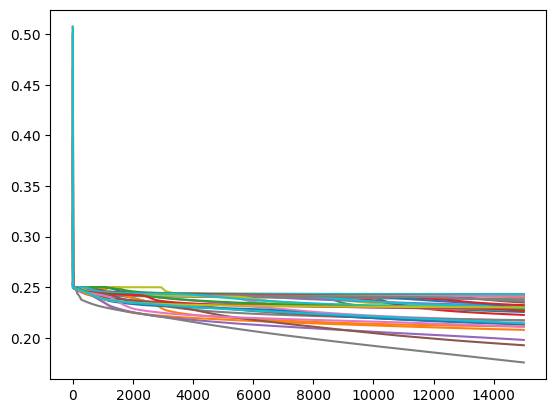

In [187]:
neurons = select_params(X_train, y_train, 1)

Rede com 10 neurônios tive melhor desempenho considerando erro de validação.

In [188]:
neurons

10

Rede de uma camada com 10 neurônios agora utilizando todos os dados de treino.

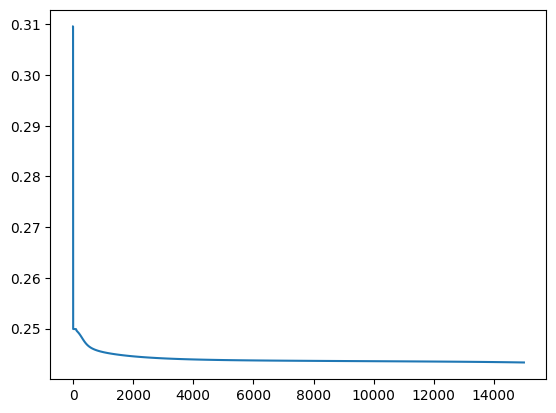

In [189]:
A, B, error_train = train(X_train, y_train, neurons, 1)

In [190]:
error_train

0.24333132495452428

Verificando erro no conjunto de teste.
Resultado próximo ao obtido com conjunto de treino, demonstrando não ter ocorrido overfit.

In [194]:
error_test = test(X_test, y_test, A, B)

In [195]:
error_test

0.25712961558573055

Gerando matriz de confusão:

In [203]:
from sklearn.metrics import classification_report

In [204]:
y_predict = neural_network_test(X_test, A, B)
y_predict = [0 if pred < 0.5 else 1 for pred in y_predict]

In [205]:
print(classification_report(y_pred=y_predict, y_true=y_test, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.47      0.63      0.54       298
           1       0.54      0.37      0.44       342

    accuracy                           0.50       640
   macro avg       0.50      0.50      0.49       640
weighted avg       0.51      0.50      0.49       640



Salvando pesos.

In [207]:
with open('A.npy', 'wb') as f:
    np.save(f, A)

In [208]:
with open('B.npy', 'wb') as f:
    np.save(f, B)

Testando recupração de pesos gravados em disco.

In [209]:
with open('A.npy', 'rb') as f:
    A_load = np.load(f)

In [210]:
with open('B.npy', 'rb') as f:
    B_load = np.load(f)

In [211]:
error_test_load = test(X_test, y_test, A_load, B_load)
error_test_load

0.25712961558573055